In [142]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
import matplotlib.pyplot as plt

# Data Preparation

In [143]:
df = pd.read_csv("./data/nan_removed_cleaned_data.csv")
df.columns

Index(['budget', 'genres', 'id', 'imdb_id', 'original_title', 'overview',
       'popularity', 'poster_path', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count',
       'log_popularity', 'title_length', 'num_languages', 'num_genres',
       'imdb_rating', 'imdb_budget', 'imdb_revenue', 'budget_currency',
       'revenue_currency', 'converted_budget', 'converted_revenue',
       'combined_budget', 'combined_revenue'],
      dtype='object')

For this Naive Bayes example, it will be interesting to classify whether a film will be a box office hit or flop based on the overview of the film.

Let's separate our data so we are only focusing on the variables at hand here.

This will be `overview`, `combined_budget`, and `combined_revenue`:

In [144]:
# Select specific columns
df = df[['overview', 'combined_budget', 'combined_revenue']]
display(df.shape[0])

# We only want data where we have an overview, and combined budget/revenue data:
df = df[df['overview'].notna()]
df = df[df['combined_budget'].notna()]
df = df[df['combined_revenue'].notna()]
df = df[df['combined_revenue'] != 0]

display(df.shape[0])

16012

4438

Cool! We only lost a couple hundred rows by removing the missing values from these columns.

Next, to form data for supervised learning, we need labeled data. In this case our labels will be binary, distingushing between box office success and failure:

In [145]:
def box_office_success(row):
    if row['combined_budget'] < row['combined_revenue']:
        return 1
    else:
        return 0

df['labels'] = df.apply(box_office_success, axis=1)

display(df.head(10))

display(df['labels'].value_counts())


,overview,combined_budget,combined_revenue,labels
0,Timo Novotny labels his new project an experim...,8.013003e+04,1871.0,0
1,"Nemo, an adventurous young clownfish, is unexp...",9.400000e+07,940986748.0,1
2,"Lester Burnham, a depressed suburban father in...",1.500000e+07,356296601.0,1
3,"Selma, a Czech immigrant on the verge of blind...",1.280000e+07,40046516.0,1
4,"In an attempt to pull her family together, Adè...",5.302639e+06,6593579.0,1
5,"In 2257, a taxi driver is unintentionally give...",9.150000e+07,263920180.0,1
6,A fatally ill mother with only two months to l...,2.353900e+06,11040927.0,1
7,Bruce Brown's The Endless Summer is one of the...,5.000000e+04,10233.0,0
8,"Jack Sparrow, a freewheeling 18th-century pira...",1.400000e+08,654637619.5,1
9,"An assassin is shot by her ruthless employer, ...",3.000000e+07,180906076.0,1


1    2242
0    2196
Name: labels, dtype: int64

Great, now we have a separation of values.

Next, we want to clean our text so it doesn't include any punctuation:

In [146]:
def remove_punct(text):
    text_new = "".join([c for c in text if c not in string.punctuation])
    return text_new

df['text_clean'] = df['overview'].apply(lambda x: remove_punct(x))
df[['text_clean', 'labels']].head(10)

,text_clean,labels
0,Timo Novotny labels his new project an experim...,0
1,Nemo an adventurous young clownfish is unexpec...,1
2,Lester Burnham a depressed suburban father in ...,1
3,Selma a Czech immigrant on the verge of blindn...,1
4,In an attempt to pull her family together Adèl...,1
5,In 2257 a taxi driver is unintentionally given...,1
6,A fatally ill mother with only two months to l...,1
7,Bruce Browns The Endless Summer is one of the ...,0
8,Jack Sparrow a freewheeling 18thcentury pirate...,1
9,An assassin is shot by her ruthless employer B...,1


For most machine learning techniques (including this one), we need to separate our data into a training and testing set.

In [147]:
#Splitting x and y
x = df['text_clean'].values
y = df['labels'].values

# Separate into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1600)

print(f'{len(x_train)} training, {len(x_test)} testing')

3550 training, 888 testing


Perfect! Now we can apply Naive Bayes to this data.

# Naive Bayes

First, we want to set up a model that can vectorize/tokenize our text data for use in the Naive Bayes algorithm.

After that, we can fit our model to the training data:

In [148]:
nb_model = make_pipeline(TfidfVectorizer(stop_words="english"), MultinomialNB())
nb_model.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('multinomialnb', MultinomialNB())])

And we can calculate metrics for our Naive Bayes performance on the test set


The confusion matrix is:


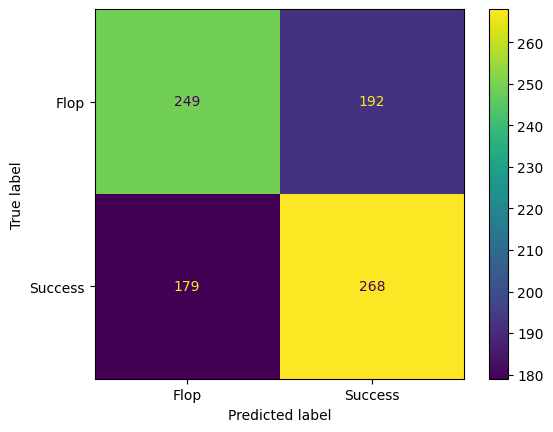

Metrics for Test Data
---------------------
Accuracy: 0.5822072072072072
Precision:
    ->Flop: 0.5817757009345794
    ->Success: 0.5826086956521739
Recall:
    ->Flop: 0.564625850340136
    ->Success: 0.5995525727069351
F1 Score:
    ->Flop: 0.5730724971231299
    ->Success: 0.5909592061742006
Support:
    ->Flop: 441
    ->Success: 447


In [149]:
class_names = ['Flop', 'Success']
# Show the predictions from the NB on the test set
test_pred = nb_model.predict(x_test)

# Show the confusion matrix
bn_matrix = confusion_matrix(y_test, test_pred)
print("\nThe confusion matrix is:")
disp = ConfusionMatrixDisplay(bn_matrix, display_labels=class_names)
disp.plot()
plt.savefig('./imgs/nb_ims/confusion_matrix.png')
plt.show()

# Print out metrics
print("Metrics for Test Data")
print("---------------------")
print(f"Accuracy: {accuracy_score(y_test, test_pred)}")

test_prec, test_recall, test_f1, test_support = precision_recall_fscore_support(y_test, test_pred)
print("Precision:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_prec[idx]}")

print("Recall:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_recall[idx]}")

print("F1 Score:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_f1[idx]}")

print("Support:")
for idx, i in enumerate(class_names):
    print(f"    ->{i}: {test_support[idx]}")